In [35]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sm

%matplotlib inline

sns.set_context("notebook", font_scale = 1.5,       
         rc = {"figure.figsize" : (50, 30),"axes.titlesize" : 12})


# ЗАДАНИЕ 1: Написать функцию, которая будет считать retention игроков(по дням от даты регистрации)

Retention – один из самых важных показателей в компании. Он показывает, какой процент новых пользователей вернулись в продукт в конкретный день с момента прихода.

Например, retention 1-го дня равен 15%, то 15% новых пользователей вернулись в продукт на следующий день после его первого использования.

Итак, нам нужно написать функцию, которая будет расчитывать retention игроков по дням от даты регистрации. Нам даны две таблицы с данными, содержащими информацию о времени регистрации игроков, а также о времени захода в игру пользователей. Данные содержат user_id(uid), и timestamp - время регистрации или аутентификации. 

In [36]:
#  выгружаем данные
auth_df = pd.read_csv('D:/jupyter_notebook/final_project/final_project_task_1_auth.csv', sep=';')
reg_df = pd.read_csv('D:/jupyter_notebook/final_project/final_project_task_1_reg.csv', sep=';')

In [37]:
# посомтрим на данные, их тип, наличие(или отсутствие) пропущенных значений, 
# а также на количество строк в каждой из таблиц
print('СОДЕРЖАНИЕ ДАТАФРЕЙМОВ: ')
print(auth_df.head(3))
print(reg_df.head(3))
print()
print('ТИПЫ ДАННЫХ: ')
print(reg_df.dtypes)
print(auth_df.dtypes)
print()
print('ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ: ')
print(f"В таблице регистрации : {reg_df.isna().sum()}")
print(f"В таблице аутентификации : {reg_df.isna().sum()}")
print()
print('КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМАХ:')
print(f"Number of rows in registration data: {reg_df.shape[0]}")
print(f"Number of rows in authentification data: {auth_df.shape[0]}")


СОДЕРЖАНИЕ ДАТАФРЕЙМОВ: 
     auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
      reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3

ТИПЫ ДАННЫХ: 
reg_ts    int64
uid       int64
dtype: object
auth_ts    int64
uid        int64
dtype: object

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ: 
В таблице регистрации : reg_ts    0
uid       0
dtype: int64
В таблице аутентификации : reg_ts    0
uid       0
dtype: int64

КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМАХ:
Number of rows in registration data: 1000000
Number of rows in authentification data: 9601013


На данные посмотрели, пропущенных нет, 1 000 000 юзеров, более 9 000 000 заходов в игру. Прежде чем писать функцию, взглянем на распределения юзеров по времени.

In [38]:
# переведем timestamp в дату
reg_df['reg_ts'] = pd.to_datetime(reg_df.reg_ts, unit='s')
auth_df['auth_ts'] = pd.to_datetime(auth_df.auth_ts, unit='s')

<AxesSubplot:xlabel='reg_ts', ylabel='Count'>

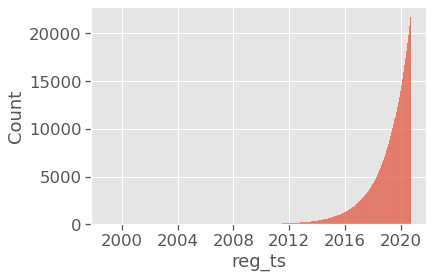

In [39]:
sns.histplot(reg_df, x='reg_ts')

<AxesSubplot:xlabel='auth_ts', ylabel='Count'>

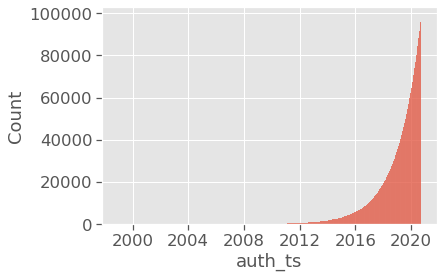

In [40]:
sns.histplot(auth_df, x='auth_ts')

По графикам видно, что большая часть данных в период с 2012 по 2020 год, до этого времени регистраций и аутентификаций было заметно меньше. Для написания функции нам это не важно, но в любом случае хотелось увидеть картину шире.

Теперь приступим к самому интересному. Так как данных у нас много (более 20 лет), а retention нам надо считать по дням с даты регистрации, разумно было бы добавить в функцию возможность выбирать период, в котором мы хотим смотреть показатели, а также выбирать, retention какого дня мы хотим посмотреть(1d, 7d, 28d и т.д.)

Вкратце опишем работу функции, а потом более подробно прокомментируем каждый шаг. Сджойним две таблицы по uid, отберем период, считаем разницу между днем регистрации и захода в игру, определяем когорты, считаем retention.

In [41]:
# вызываем функцию, в параметрах два датасета(reg_data, auth_data), 
# выбор n day retention(n), период год-месяц-день(y_1, m_1, d_1, y_2, m_2, d_2)
def calculate_retention(reg_data, auth_data, n, y_1, m_1, d_1, y_2, m_2, d_2):
    
    # переведем timestamp к дате     
    reg_df['reg_ts'] = pd.to_datetime(reg_df.reg_ts, unit='s')
    auth_df['auth_ts'] = pd.to_datetime(auth_df.auth_ts, unit='s')
    
    # соединим два датасета, используя left join, для того,
    # чтобы каждому auth date соответствовал reg date     
    temp_df = auth_df.merge(reg_df, how='left', on='uid')
    
    # необязательный шаг, меняющий местами колонки     
    cols = temp_df.columns.to_list()
    cols = cols[1] + ' ' + cols[0] + ' ' + cols[-1]
    cols = cols.split(' ')
    temp_df = temp_df[cols]
    
    # добавим колонки с днем регистрации и аутентификации    
    temp_df['reg_day'] = temp_df.reg_ts.dt.date
    temp_df['auth_day'] = temp_df.auth_ts.dt.date
    
    # отбираем из датасета необходимый для расчета период 
    main_df = temp_df[(temp_df.reg_day >= dt.date(year=y_1,month=m_1,day=d_1)) & \
                      (temp_df.reg_day <= dt.date(year=y_2,month=m_2,day=d_2))]
    
    # считаем разность дня аутент. с днем регистрации      
    main_df = main_df.assign(datediff=(main_df.auth_day - main_df.reg_day))
    
    # группируем по дню регистрации и по разности, считаем число пользователей,
    # которые зарегистрировались в какой-то день, 
    # и через сколько дней после регистрации они зашли в игру
    temp_df_2 = main_df \
                        .groupby(['reg_day', 'datediff'], as_index=False) \
                        .agg({'uid': pd.Series.nunique}) \
                        .rename(columns={'datediff': 'days_after_reg'})
    
    # переворачиваем таблицу, делая колонками дни после регистрации,
    # значения - число пользователей в каждый из дней, строки - день регистрации,
    # предварительно выбрав n day retention    
    pivoted = temp_df_2[temp_df_2.days_after_reg <= pd.Timedelta(n, 'd')] \
                       .pivot(columns = 'days_after_reg', values = 'uid', index='reg_day')
    
   
    # считаем retention в процентах, разделив датафрейм по индексам,
    # также переводя значение числа пользователей в проценты,
    # где в 1 колонке будет 100%
    sizes = pivoted.iloc[:,0]
    retention = pivoted.divide(sizes, axis=0)
    retention = retention.round(2)
    retention = retention \
                            .style.format("{:.2%}", na_rep='') \
                            .background_gradient(cmap="Blues")
    
    return retention
    

In [42]:
# проверяем работу функции, считаем 7-day retention в период с 1.09.19 - 1.10.19
calculate_retention(reg_df, auth_df, 7, 2019, 9, 1, 2019, 10, 1)

days_after_reg,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00
reg_day,,,,,,,,
2019-09-01,100.00%,2.00%,5.00%,5.00%,4.00%,7.00%,8.00%,7.00%
2019-09-02,100.00%,2.00%,4.00%,4.00%,5.00%,6.00%,6.00%,6.00%
2019-09-03,100.00%,2.00%,3.00%,5.00%,6.00%,5.00%,7.00%,5.00%
2019-09-04,100.00%,1.00%,3.00%,5.00%,4.00%,6.00%,7.00%,7.00%
2019-09-05,100.00%,2.00%,4.00%,5.00%,5.00%,6.00%,7.00%,7.00%
2019-09-06,100.00%,2.00%,4.00%,4.00%,4.00%,6.00%,7.00%,6.00%
2019-09-07,100.00%,2.00%,5.00%,4.00%,4.00%,5.00%,9.00%,6.00%
2019-09-08,100.00%,1.00%,4.00%,4.00%,6.00%,6.00%,6.00%,7.00%
2019-09-09,100.00%,2.00%,3.00%,4.00%,5.00%,5.00%,7.00%,4.00%


In [43]:
# 28-day retention в период с 25.08.20 - 05.09.20
calculate_retention(reg_df, auth_df, 28, 2020, 8, 25, 2020, 9, 5)

days_after_reg,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00,8 days 00:00:00,9 days 00:00:00,10 days 00:00:00,11 days 00:00:00,12 days 00:00:00,13 days 00:00:00,14 days 00:00:00,15 days 00:00:00,16 days 00:00:00,17 days 00:00:00,18 days 00:00:00,19 days 00:00:00,20 days 00:00:00,21 days 00:00:00,22 days 00:00:00,23 days 00:00:00,24 days 00:00:00,25 days 00:00:00,26 days 00:00:00,27 days 00:00:00,28 days 00:00:00
reg_day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-08-25,100.00%,2.00%,4.00%,5.00%,6.00%,5.00%,5.00%,6.00%,4.00%,6.00%,5.00%,5.00%,4.00%,5.00%,4.00%,5.00%,4.00%,4.00%,4.00%,4.00%,4.00%,4.00%,4.00%,3.00%,3.00%,4.00%,3.00%,3.00%,3.00%
2020-08-26,100.00%,1.00%,3.00%,4.00%,5.00%,6.00%,7.00%,6.00%,5.00%,4.00%,4.00%,6.00%,5.00%,4.00%,5.00%,3.00%,4.00%,4.00%,4.00%,4.00%,4.00%,3.00%,4.00%,3.00%,3.00%,3.00%,3.00%,3.00%,2.00%
2020-08-27,100.00%,2.00%,3.00%,5.00%,5.00%,6.00%,6.00%,6.00%,4.00%,5.00%,5.00%,5.00%,4.00%,5.00%,4.00%,5.00%,4.00%,5.00%,4.00%,4.00%,4.00%,5.00%,3.00%,3.00%,4.00%,3.00%,3.00%,1.00%,
2020-08-28,100.00%,2.00%,5.00%,5.00%,5.00%,6.00%,6.00%,5.00%,6.00%,5.00%,5.00%,5.00%,5.00%,4.00%,5.00%,5.00%,5.00%,5.00%,4.00%,4.00%,4.00%,4.00%,5.00%,4.00%,3.00%,4.00%,3.00%,,
2020-08-29,100.00%,3.00%,4.00%,5.00%,6.00%,6.00%,7.00%,6.00%,5.00%,6.00%,4.00%,5.00%,7.00%,5.00%,5.00%,5.00%,5.00%,4.00%,4.00%,4.00%,3.00%,4.00%,4.00%,3.00%,4.00%,2.00%,,,
2020-08-30,100.00%,2.00%,3.00%,4.00%,5.00%,6.00%,7.00%,6.00%,4.00%,4.00%,5.00%,5.00%,5.00%,5.00%,4.00%,4.00%,3.00%,4.00%,4.00%,4.00%,4.00%,4.00%,4.00%,4.00%,2.00%,,,,
2020-08-31,100.00%,2.00%,4.00%,4.00%,5.00%,7.00%,7.00%,7.00%,5.00%,5.00%,5.00%,5.00%,5.00%,4.00%,4.00%,5.00%,5.00%,4.00%,4.00%,5.00%,3.00%,4.00%,3.00%,2.00%,,,,,
2020-09-01,100.00%,2.00%,4.00%,4.00%,5.00%,6.00%,6.00%,6.00%,4.00%,5.00%,5.00%,5.00%,5.00%,5.00%,4.00%,4.00%,4.00%,5.00%,4.00%,4.00%,4.00%,4.00%,2.00%,,,,,,
2020-09-02,100.00%,3.00%,4.00%,5.00%,6.00%,6.00%,7.00%,6.00%,5.00%,4.00%,6.00%,5.00%,5.00%,4.00%,5.00%,5.00%,4.00%,5.00%,4.00%,4.00%,5.00%,3.00%,,,,,,,


Функция позволяет посмотреть retention в любой нужный нам период, и уже после можно провести анализ возвращаемости. 

Вывод, который можно сделать относительно пользователей и их вовлеченности именно в этой игре таков: показатель retention в целом довольно низкий с самого первого дня. Очень маленький процент пользователей возвращается в игру после регистрации. Стоит сильно задуматься над тем, как удерживать игроков, например, присылать ненавязчивые уведомления, поработать над обратной связью, узнать, что нравится или не нравится игрокам, постараться улучшить контент, чтобы игроки хотели чаще заходить в игру, а если там есть внутриигровая валюта, сделать небольшой подарок или бонус за вход в игру, проводить внутриигровые ивенты с различными призами и так далее. 


# ЗАДАНИЕ 2:

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [44]:
# считаем данные
df = pd.read_csv('D:/jupyter_notebook/final_project/final_project_task_2.csv', sep=';')

In [45]:
# для удобства разделим данные на контрольную и тестовую группу
control = df[df.testgroup == 'a']
test = df[df.testgroup == 'b']

In [46]:
# посмотрим на данные, имеется user_id, выручка на каждого пользователя,
# а также разделение на группы
control.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [47]:
test.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


Прежде, чем делать анализировать результаты АБ-теста, проверим показатели из условия.

In [48]:
# расчитаем ARPU в контрольной группе
arpu_control = control.groupby('testgroup').revenue.mean().values[0]
arpu_control

25.413719736965806

In [49]:
# расчитаем ARPU в тестовой группе
arpu_test = test.groupby('testgroup').revenue.mean().values[0]
arpu_test

26.75128659327863

In [50]:
100 - (arpu_control / arpu_test * 100)

5.000009444962146

Действительно, ARPU в тестовой группе больше на 5%. Теперь посмотрим общую выручку в обеих группах.

In [51]:
# выручка в контрольной группе
control.groupby('testgroup').revenue.sum().values[0]

5136189

In [52]:
# выручка в тестовой группе
test.groupby('testgroup').revenue.sum().values[0]

5421603

Теперь взглянем на количество платящих пользователей.

In [53]:
# количество платящих пользователей в контрольной группе
control[control.revenue > 0].shape[0]

1928

In [54]:
# количество платящих пользователей в тестовой группе
test[test.revenue > 0].shape[0]

1805

Теперь, когда мы посмотрели все показатели из условия, следует проанализировать результаты. Для начала посмотрим на среднюю выручку на платящего пользователя.

In [55]:
# ARPPU в контрольной группе
arppu_control = control[control.revenue > 0].groupby('testgroup').agg({'revenue': 'mean'}).values[0][0]
arppu_control

2663.9984439834025

In [56]:
# ARPPU в тестовой группе
arppu_test = test[test.revenue > 0].groupby('testgroup').agg({'revenue': 'mean'}).values[0][0]
arppu_test

3003.6581717451522

In [57]:
100 - (arppu_control / arppu_test * 100)

11.308201810607642

ARPPU в тестовой группе больше на ~11%. 

Теперь нужно понять, какой статистический критерий выбрать для анализа результатов АБ-теста, и понять, различаются ли две группы статистически значимо, или это просто случайные различия.
Как мне кажется, нужно проанализировать не только все распределение, но и распределение платящих пользователей отдельно, чтобы понять, как влияют акционные предложение на них отдельно.

Для начала посмотрим на гистрограмму распределений, чтобы понять, какие распределения у нас есть, есть ли там выбросы, близки ли они к нормальным и так далее.

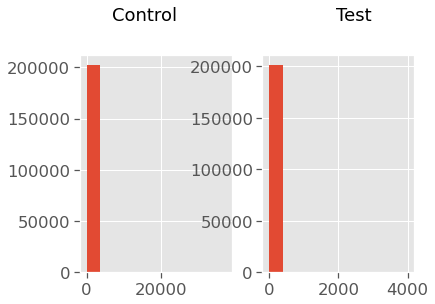

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False)

ax2.hist(test.revenue)
ax1.hist(control.revenue)

plt.text(.8, 1, 'Test', transform=fig.transFigure, horizontalalignment='right')
plt.text(.2, 1, 'Control', transform=fig.transFigure, horizontalalignment='left')

plt.show()

Итак, сразу видно, что распределение явно ненормальное, с выбросами, но графики в этом случае не совсем показательны. Воспользуемся критерием Шапиро-Уилка для проверки распределений на нормальность, предварительно взяв рандомные сэмплы из выборок, так как тест Шапиро-Уилка плохо работает на больших данных.

In [59]:
ss.shapiro(control.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [60]:
ss.shapiro(test.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

Теперь мы окончаельно убедились, что распределение ненормальное, с выбросами(p-value в тесте Шапиро-Уилка говорит о том, что наше распределение стат. значимо отличается от нормального распределения). 

Настало время выбрать необходимый стат. критерий. В нашем случае нам подойдет непараметрический критерий Манна-Уитни, который будет сравнивать ранговые значения в выборках.
 

In [61]:
ss.mannwhitneyu(control.revenue, test.revenue).pvalue

0.06269701316074398

Итак, p-уровень значимости оказался больше 0.05, что говорит нам о том, что стат. значимых различий в этих группах не наблюдается. 

Но мы пойдем немного дальше, и также посомтрим на только платящих пользователей, и проверим, есть ли стат. значимые различия в этих группах.

Для начала также построим графики, посмотрим на распределения(хотя вряд ли они нам что-то скажут).

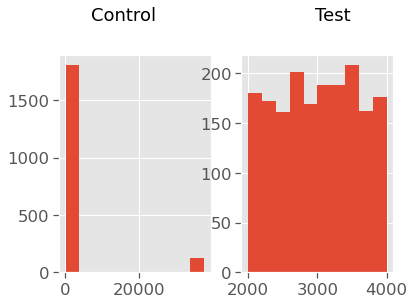

In [62]:
fig, (ax3, ax4) = plt.subplots(1, 2, sharex=False)

ax3.hist(control[control.revenue > 0].revenue)
ax4.hist(test[test.revenue > 0].revenue)

plt.text(.8, 1, 'Test', transform=fig.transFigure, horizontalalignment='right')
plt.text(.2, 1, 'Control', transform=fig.transFigure, horizontalalignment='left')

plt.show()

В контрольной группе заметны выбросы, тогда как в тестовой распределение более равномерно. Можно выдвинуть предположение, что группы неравномерны, и сравнивать их друг другом не имеет смысла, но.....мы этого делать не будем :) И продолжим исследование.

Теперь есть смысл посмотреть, есть ли различия между этими пользователями. 
Для этого воспользуемся бутстрэпом. Бутстрэп - это стат.метод, который основан на многократном извлечении бут-выборок(выборки с возвращением) из имеющейся выборки(метод Монте-Карло).

Для начала посмотрим на гистограмму бут выборок, а также на p-уровень значимости. Сравнивать будем медианные значения, потому как в данных есть много выбросов, и бутстрэп для сравнения средних сильно чувствителен к выбросам, и может исказить выводы, и возрастает вероятность ошибки первого рода( мы отклонили нулевую гипотезу, когда различий на самом деле нет). Поэтому будем сравнивать медианы.

In [63]:
# обозначаем функию(две выборки, колчество бут-выборок, статистика, уровень значимости)
def get_bootstrap(df_data_1, df_data_2, boot_it = 1000, statistic = np.mean, conf_level = 0.95):
    
    # считаем размер бут-выборок     
    boot_len = max([len(df_data_1), len(df_data_2)])
    boot_data = []
    
    for i in range(boot_it): 
        # делаем два семпла из выборок, с возвращением        
        samples_1 = df_data_1.sample(boot_len, replace = True).values
        samples_2 = df_data_2.sample(boot_len, replace = True).values
        
        # добавляем в бут-дату среднее или медианное значение разности сэмплов
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    # находим доверительный интревал для разности медиан\средних\любой статистики         
    left_quant = (1 - conf_level)/2
    right_quant = 1 - (1 - conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    
    # находим уровень значимости     
    p_1 = ss.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = ss.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # визуализируем бут-дату
    plt.hist(pd_boot_data[0], bins = 50, color='lightblue')
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=75,linestyle='dotted', colors='r')
    plt.xlabel('Бут дата')
    plt.ylabel('Частота')
    plt.title("Гистограмма Бутстрэп Выборок")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

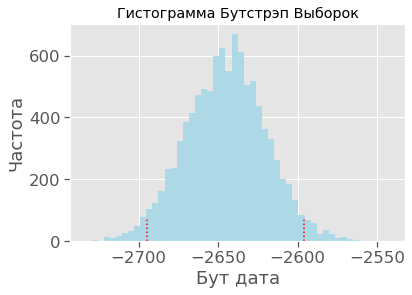

In [64]:
# применим бутстрап, для сравнения медиан, возьмем 10000 бут выборок
boot_data_median = get_bootstrap(control[control.revenue > 0].revenue, 
                                 test[test.revenue > 0].revenue, 
                                 boot_it = 10000, 
                                 statistic=np.median)

График распределения разности медиан(гистограмма бут-даты) говорит нам о том, что разность медианных значение лежит в промежутке, где нет нуля, то есть разность не равна нулю, а значит, различия наблюдаются.

In [65]:
print(f"P_value при применении бутстрэпа для сравнения медиан: {boot_data_median['p_value']}")

P_value при применении бутстрэпа для сравнения медиан: 0.0


In [66]:
print(f"Доверительный интервал при применении бутстрэпа для разности медиан: {boot_data_median['ci']}")

Доверительный интервал при применении бутстрэпа для разности медиан:             0
0.025 -2695.0
0.975 -2596.0


Р-уровень значимости нам говорит о том, что различия конкретно в этих группах статистически значимы.

Какой вывод мы можем сделать из всего этого. 

Если мы сравниваем всех пользователей, платящих и не платящих, различий мы не получаем(стат. значимых), и поэтому нет оснований отклонить нулевую гипотезу о том, что различий между группами нет. Но, если мы сравним только платящих пользователей, увидим, что различия есть. Таким образом, есть смысл использовать набор акционных предложений, который был показан тестовой группе, так как это стат.значимо повышает все нужные нам ключевые метрики.

# ЗАДАНИЕ 3:

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

=======================================================================================================================

Давайте попробуем разобраться, какие метрики мы будем оценивать для подведения итогов тематических событий. 

1. Для начала есть смысл посмотреть на среднее время сессии в период ивента, выросло оно или нет, а также сравнить его со средним временем сессии в целом в другой схожий по времени период, чтобы понимать, возрос ли интерес к игре, проводят ли больше игроки времени в игре. 


2. Также стоит рассмотреть DAU в период ивента, по нему можно судить об успешности ивента.


3. Если в игре есть внутриигровые покупки(бустеры и т.п.), стоит посмотреть на количество и сумму покупок в период ивента, если сам по себе ивент сложный, но дает при этом крутые рарные награды, нужно понимать, сколько юзеры тратят денег на прохождение этого ивента.


4. Еще стоит оценить конверсию в получение награды, то есть сколько пользователей, кто начал ивент, дошел до конца, ну и, соотвественно конверсию по прохождению всех уровней, чтобя понять, на каком уровне пользователи испытывали трудности и дропали ивент.


Если изменить механику события, и при неудачной попытке игрок будет откатываться назад на несколько уровней назад, следует:

1. Оценить процент оттока юзеров во время ивента(Churn rate), сколько юзеров отвалится из-за усложнения игрового процесса.


2. Номера уровней, на которых игроки заканчивали ивент, чтобы в будущем подправить сложность.


3. Среднее время сессии, если оно упадет, и мы это статистически проверим, то можно судить о неудачности фичи и в следующих ивентах выбрать другой вариант механики.


4. Среднее количество попыток на прохождение уровня юзерами до момента их ухода из ивента. Также поможет нам в будущем понимать, насколько легко или сложно им было проходить ивент, и переработать механику в будущих событиях.